### This notebook contains the codes to generate all the plots used in the manuscript.
### Author: Chop Yan Lee

In [1]:
import pandas as pd
import numpy as np
from pymol import cmd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sp
import glob, os, json, pickle, sqlalchemy, db_utils
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from statannotations.Annotator import Annotator
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)
connect = db_utils.get_connection()

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [3]:
def parse_prediction_name(prediction_name):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run37_DEG_APCC_KENBOX_2_4GGD)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        pdb_id (str): PDB ID
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    dmi_name = '_'.join(splits[1:-1])
    pdb_id = splits[-1]
    return [run_id, dmi_name, pdb_id]

To test the effect of not using template during AlphaFold prediction, I will make scatterplot to see the correlation of runs done with template and without template. I will do the same with runs using use_precomputed_msas toggled on.

In [4]:
# set up a list of column names to keep only the useful ones in the dataframe
useful_cols = ['prediction_name', 'run_id','model_confidence','chainA_intf_avg_plddt', 'chainB_intf_avg_plddt',
       'intf_avg_plddt','RMSD_backbone_peptide','RMSD_all_atom_peptide', 'known_motif_plddt', 'DockQ',
       'dmi_name', 'pdb_id']

In [5]:
# Gather information of run37 which was predicted with template and without using precomputed msas
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run37' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run37 = pd.read_sql_query(query,con=connect)

run37[['run_id','dmi_name','pdb_id']] = run37.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run37.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
run37 = run37.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
run37.reset_index(drop=True,inplace=True)
print(run37.shape)

run37 = run37[useful_cols].copy()
run37.head()

(680, 29)
(136, 29)


,prediction_name,run_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,dmi_name,pdb_id
0,run37_DEG_SIAH_1_2A25,run37,0.920907,96.165000,92.233334,95.023548,0.506651,0.787199,None,0.959,DEG_SIAH_1,2A25
1,run37_DOC_USP7_MATH_1_3MQS,run37,0.923664,98.181667,93.685999,96.859411,0.608205,0.795526,None,0.976,DOC_USP7_MATH_1,3MQS
2,run37_DOC_PP2B_PxIxI_1_4F0Z,run37,0.950851,97.779376,93.825715,96.576088,0.420731,0.811035,None,0.959,DOC_PP2B_PxIxI_1,4F0Z
3,run37_DEG_Kelch_Keap1_1_2FLU,run37,0.938596,98.748889,88.666667,96.228333,0.436000,0.914587,None,0.968,DEG_Kelch_Keap1_1,2FLU
4,run37_LIG_TRAF2_2_1CZY,run37,0.861203,97.032381,82.186666,93.733333,0.643906,0.914688,None,0.961,LIG_TRAF2_2,1CZY


In [6]:
run37.columns

Index(['prediction_name', 'run_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'dmi_name', 'pdb_id'],
      dtype='object')

In [7]:
# Gather information of run44 which was predicted with template and using precomputed msas
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run44' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run44 = pd.read_sql_query(query,con=connect)

run44[['run_id','dmi_name','pdb_id']] = run44.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run44.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
run44 = run44.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
run44.reset_index(drop=True,inplace=True)
print(run44.shape)

run44 = run44[useful_cols].copy()
run44.head()

(670, 29)
(134, 29)


,prediction_name,run_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,dmi_name,pdb_id
0,run44_DEG_SIAH_1_2A25,run44,0.920797,96.226818,92.396666,95.114838,0.515196,0.793730,None,0.958,DEG_SIAH_1,2A25
1,run44_DOC_PP2B_PxIxI_1_4F0Z,run44,0.952013,97.802500,93.965714,96.634782,0.423505,0.806526,None,0.959,DOC_PP2B_PxIxI_1,4F0Z
2,run44_DOC_USP7_MATH_1_3MQS,run44,0.901727,98.038462,91.344000,96.178889,0.621087,0.808293,None,0.960,DOC_USP7_MATH_1,3MQS
3,run44_DEG_SPOP_SBC_1_3HQM,run44,0.919230,98.512858,92.491998,96.928421,0.849934,0.863455,None,0.955,DEG_SPOP_SBC_1,3HQM
4,run44_DEG_Kelch_Keap1_1_2FLU,run44,0.936057,98.747222,88.075001,96.079167,0.437864,0.904082,None,0.968,DEG_Kelch_Keap1_1,2FLU


In [8]:
# Gather information of run45 which was predicted without template and without using precomputed msas
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run45' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run45 = pd.read_sql_query(query,con=connect)

run45[['run_id','dmi_name','pdb_id']] = run45.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run45.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
run45 = run45.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
run45.reset_index(drop=True,inplace=True)
print(run45.shape)

run45 = run45[useful_cols].copy()
run45.head()

(670, 29)
(134, 29)


,prediction_name,run_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,dmi_name,pdb_id
0,run45_DOC_USP7_MATH_1_3MQS,run45,0.773167,97.225001,75.896001,90.951766,0.568018,0.721602,None,0.954,DOC_USP7_MATH_1,3MQS
1,run45_DEG_SIAH_1_2A25,run45,0.912742,95.478182,92.091112,94.494839,0.442764,0.738327,None,0.956,DEG_SIAH_1,2A25
2,run45_DOC_PP2B_PxIxI_1_4F0Z,run45,0.952021,97.593530,94.114285,96.578750,0.433835,0.812267,None,0.966,DOC_PP2B_PxIxI_1,4F0Z
3,run45_DEG_Kelch_Keap1_1_2FLU,run45,0.935797,98.454211,93.081666,97.164800,0.390977,0.912917,None,0.928,DEG_Kelch_Keap1_1,2FLU
4,run45_LIG_TRAF2_2_1CZY,run45,0.874986,96.564285,85.263335,94.052963,0.627432,0.972433,None,0.968,LIG_TRAF2_2,1CZY


Now merge the three runs into one single dataframe. There are discrepancy in datapoint because later on in MMv2.3 I changed the pdb_id of some DMI types. To create a single list of DMI types that are comparable between runs, I will join the tables on their dmi name and pdb id.

In [9]:
temp = pd.merge(run37,run44,how='inner',left_on=['dmi_name','pdb_id'],right_on=['dmi_name','pdb_id'],
         suffixes=['','_run44'])
final_df = pd.merge(temp,run45,how='inner',left_on=['dmi_name','pdb_id'],right_on=['dmi_name','pdb_id'],
         suffixes=['_run37','_run45'])
final_df

,prediction_name_run37,run_id_run37,model_confidence_run37,chainA_intf_avg_plddt_run37,chainB_intf_avg_plddt_run37,intf_avg_plddt_run37,RMSD_backbone_peptide_run37,RMSD_all_atom_peptide_run37,known_motif_plddt_run37,DockQ_run37,...,prediction_name_run45,run_id_run45,model_confidence_run45,chainA_intf_avg_plddt_run45,chainB_intf_avg_plddt_run45,intf_avg_plddt_run45,RMSD_backbone_peptide_run45,RMSD_all_atom_peptide_run45,known_motif_plddt_run45,DockQ_run45
0,run37_DEG_SIAH_1_2A25,run37,0.920907,96.165000,92.233334,95.023548,0.506651,0.787199,None,0.959,...,run45_DEG_SIAH_1_2A25,run45,0.912742,95.478182,92.091112,94.494839,0.442764,0.738327,None,0.956
1,run37_DOC_USP7_MATH_1_3MQS,run37,0.923664,98.181667,93.685999,96.859411,0.608205,0.795526,None,0.976,...,run45_DOC_USP7_MATH_1_3MQS,run45,0.773167,97.225001,75.896001,90.951766,0.568018,0.721602,None,0.954
2,run37_DOC_PP2B_PxIxI_1_4F0Z,run37,0.950851,97.779376,93.825715,96.576088,0.420731,0.811035,None,0.959,...,run45_DOC_PP2B_PxIxI_1_4F0Z,run45,0.952021,97.593530,94.114285,96.578750,0.433835,0.812267,None,0.966
3,run37_DEG_Kelch_Keap1_1_2FLU,run37,0.938596,98.748889,88.666667,96.228333,0.436000,0.914587,None,0.968,...,run45_DEG_Kelch_Keap1_1_2FLU,run45,0.935797,98.454211,93.081666,97.164800,0.390977,0.912917,None,0.928
4,run37_LIG_TRAF2_2_1CZY,run37,0.861203,97.032381,82.186666,93.733333,0.643906,0.914688,None,0.961,...,run45_LIG_TRAF2_2_1CZY,run45,0.874986,96.564285,85.263335,94.052963,0.627432,0.972433,None,0.968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,run37_LIG_FAT_LD_1_3GM1,run37,0.885796,97.547857,87.994284,94.363333,27.864506,27.508253,None,0.035,...,run45_LIG_FAT_LD_1_3GM1,run45,0.886894,97.376428,88.077142,94.276666,27.866814,27.505966,None,0.035
130,run37_LIG_Clathr_ClatBox_2_1UTC,run37,0.545352,91.812667,34.396000,77.458500,31.930944,31.001265,None,0.031,...,run45_LIG_Clathr_ClatBox_2_1UTC,run45,0.501079,90.164999,31.534000,76.205238,30.818237,30.537954,None,0.033
131,run37_DOC_PP1_MyPhoNE_1_1S70,run37,0.611319,92.971250,39.842500,75.261667,39.559898,39.227875,None,0.019,...,run45_DOC_PP1_MyPhoNE_1_1S70,run45,0.602310,91.205833,38.653750,70.185000,38.989296,38.897526,None,0.019
132,run37_LIG_APCC_ABBA_1_4BH6,run37,0.446541,94.432500,28.864000,69.213846,40.184631,40.003876,None,0.019,...,run45_LIG_APCC_ABBA_1_4BH6,run45,0.468971,93.945556,30.404999,68.529333,39.756828,39.633778,None,0.019


In [10]:
final_df.columns

Index(['prediction_name_run37', 'run_id_run37', 'model_confidence_run37',
       'chainA_intf_avg_plddt_run37', 'chainB_intf_avg_plddt_run37',
       'intf_avg_plddt_run37', 'RMSD_backbone_peptide_run37',
       'RMSD_all_atom_peptide_run37', 'known_motif_plddt_run37', 'DockQ_run37',
       'dmi_name', 'pdb_id', 'prediction_name_run44', 'run_id_run44',
       'model_confidence_run44', 'chainA_intf_avg_plddt_run44',
       'chainB_intf_avg_plddt_run44', 'intf_avg_plddt_run44',
       'RMSD_backbone_peptide_run44', 'RMSD_all_atom_peptide_run44',
       'known_motif_plddt_run44', 'DockQ_run44', 'prediction_name_run45',
       'run_id_run45', 'model_confidence_run45', 'chainA_intf_avg_plddt_run45',
       'chainB_intf_avg_plddt_run45', 'intf_avg_plddt_run45',
       'RMSD_backbone_peptide_run45', 'RMSD_all_atom_peptide_run45',
       'known_motif_plddt_run45', 'DockQ_run45'],
      dtype='object')

### Compare run37 and run44 (use precomputed msas)

PearsonRResult(statistic=0.8438061286360115, pvalue=1.7073267347982889e-37)


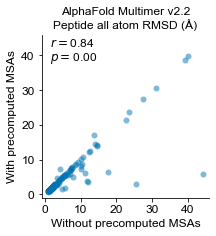

In [11]:
# check the correlation of RMSD_all_atom_peptide between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/use_precomputed_msas/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['RMSD_all_atom_peptide_run37'],final_df['RMSD_all_atom_peptide_run44'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['RMSD_all_atom_peptide_run37'], final_df['RMSD_all_atom_peptide_run44'], alpha=0.5,
            linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=10, y_minor_multiple=10)


# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('With precomputed MSAs', fontsize=global_fontsize)
plt.xlabel('Without precomputed MSAs', fontsize=global_fontsize)
plt.ylim([-1,46])
plt.xlim([-1,46])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nPeptide all atom RMSD (Å)',fontsize=global_fontsize)

plt.savefig(f'{save_path}precomputed_msas_all_atom_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}precomputed_msas_all_atom_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.8380253938806247, pvalue=1.5378253363662365e-36)


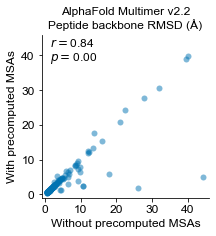

In [12]:
# check the correlation of RMSD_backbone_peptide between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/use_precomputed_msas/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['RMSD_backbone_peptide_run37'],final_df['RMSD_backbone_peptide_run44'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['RMSD_backbone_peptide_run37'], final_df['RMSD_backbone_peptide_run44'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=10, y_minor_multiple=10)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('With precomputed MSAs', fontsize=global_fontsize)
plt.xlabel('Without precomputed MSAs', fontsize=global_fontsize)
plt.ylim([-1,46])
plt.xlim([-1,46])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nPeptide backbone RMSD (Å)',fontsize=global_fontsize)

plt.savefig(f'{save_path}precomputed_msas_backbone_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}precomputed_msas_backbone_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.91281934687674, pvalue=3.4515037145492234e-53)


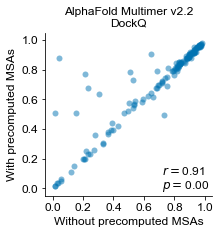

In [13]:
# check the correlation of DockQ between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/use_precomputed_msas/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['DockQ_run37'],final_df['DockQ_run44'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['DockQ_run37'], final_df['DockQ_run44'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('With precomputed MSAs', fontsize=global_fontsize)
plt.xlabel('Without precomputed MSAs', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])

plt.text(0.7,0.04,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nDockQ',fontsize=global_fontsize)

plt.savefig(f'{save_path}precomputed_msas_DockQ_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}precomputed_msas_DockQ_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.9303954970952852, pvalue=2.1796213159179744e-59)


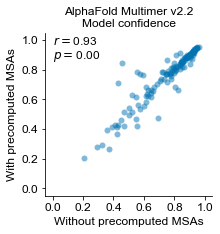

In [14]:
# check the correlation of model_confidence between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/use_precomputed_msas/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['model_confidence_run37'],final_df['model_confidence_run44'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['model_confidence_run37'], final_df['model_confidence_run44'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('With precomputed MSAs', fontsize=global_fontsize)
plt.xlabel('Without precomputed MSAs', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nModel confidence',fontsize=global_fontsize)

plt.savefig(f'{save_path}precomputed_msas_model_confidence_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}precomputed_msas_model_confidence_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.9249682793573912, pvalue=6.824720799925926e-57)


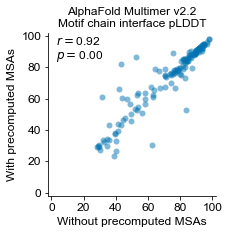

In [15]:
# check the correlation of chainB_intf_avg_plddt between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/use_precomputed_msas/'

# plot a scatterplot of the two metrics' correlation
temp = final_df[(final_df['chainB_intf_avg_plddt_run37'].notna()) & (final_df['chainB_intf_avg_plddt_run44'].notna())].copy()
cor = sp.pearsonr(temp['chainB_intf_avg_plddt_run37'],temp['chainB_intf_avg_plddt_run44'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(temp['chainB_intf_avg_plddt_run37'], temp['chainB_intf_avg_plddt_run44'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=20, x_minor_multiple=20, y_major_multiple=20, y_minor_multiple=20)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('With precomputed MSAs', fontsize=global_fontsize)
plt.xlabel('Without precomputed MSAs', fontsize=global_fontsize)
plt.ylim([-2,102])
plt.xlim([-2,102])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nMotif chain interface pLDDT',fontsize=global_fontsize)

plt.savefig(f'{save_path}precomputed_msas_motif_chain_intf_avg_plddt_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}precomputed_msas_motif_chain_intf_avg_plddt_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

### Compare run37 and run45 (max_template_date = 1950-01-01)

PearsonRResult(statistic=0.8142497861406602, pvalue=5.646550661709428e-33)


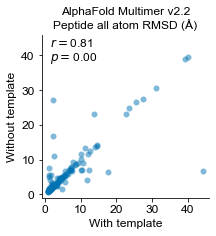

In [16]:
# check the correlation of RMSD_all_atom_peptide between run37 and run45 (no template)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/no_template/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['RMSD_all_atom_peptide_run37'],final_df['RMSD_all_atom_peptide_run45'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['RMSD_all_atom_peptide_run37'], final_df['RMSD_all_atom_peptide_run45'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=10, y_minor_multiple=10)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Without template', fontsize=global_fontsize)
plt.xlabel('With template', fontsize=global_fontsize)
plt.ylim([-1,46])
plt.xlim([-1,46])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nPeptide all atom RMSD (Å)',fontsize=global_fontsize)

plt.savefig(f'{save_path}with_without_template_all_atom_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}with_without_template_all_atom_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.8103789993215669, pvalue=1.922011638124902e-32)


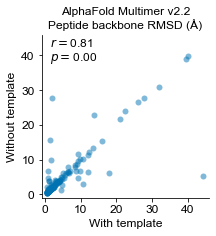

In [17]:
# check the correlation of RMSD_backbone_peptide between run37 and run45 (no template)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/no_template/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['RMSD_backbone_peptide_run37'],final_df['RMSD_backbone_peptide_run45'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['RMSD_backbone_peptide_run37'], final_df['RMSD_backbone_peptide_run45'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=10, y_minor_multiple=10)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Without template', fontsize=global_fontsize)
plt.xlabel('With template', fontsize=global_fontsize)
plt.ylim([-1,46])
plt.xlim([-1,46])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nPeptide backbone RMSD (Å)',fontsize=global_fontsize)

plt.savefig(f'{save_path}with_without_template_backbone_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}with_without_template_backbone_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.8765930070039128, pvalue=9.287784954690153e-44)


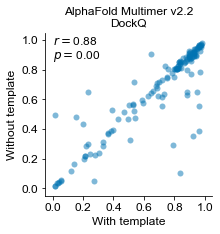

In [18]:
# check the correlation of DockQ between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/no_template/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['DockQ_run37'],final_df['DockQ_run45'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['DockQ_run37'], final_df['DockQ_run45'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Without template', fontsize=global_fontsize)
plt.xlabel('With template', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nDockQ',fontsize=global_fontsize)

plt.savefig(f'{save_path}with_without_template_DockQ_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}with_without_template_DockQ_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.8367040440996707, pvalue=2.5109918262902856e-36)


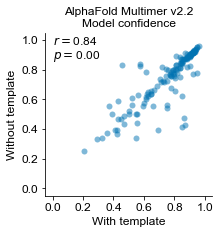

In [19]:
# check the correlation of model_confidence between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/no_template/'

# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['model_confidence_run37'],final_df['model_confidence_run45'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(final_df['model_confidence_run37'], final_df['model_confidence_run45'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Without template', fontsize=global_fontsize)
plt.xlabel('With template', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nModel confidence',fontsize=global_fontsize)

plt.savefig(f'{save_path}with_without_template_model_confidence_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}with_without_template_model_confidence_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

PearsonRResult(statistic=0.8516897030386518, pvalue=1.4073586460903727e-38)


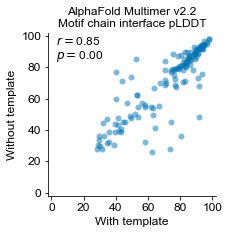

In [20]:
# check the correlation of chainB_intf_avg_plddt between run37 and run44 (reuse msas)
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/no_template/'

# plot a scatterplot of the two metrics' correlation
temp = final_df[(final_df['chainB_intf_avg_plddt_run37'].notna()) & (final_df['chainB_intf_avg_plddt_run45'].notna())].copy()
cor = sp.pearsonr(temp['chainB_intf_avg_plddt_run37'],temp['chainB_intf_avg_plddt_run45'])
print(cor)

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(temp['chainB_intf_avg_plddt_run37'], temp['chainB_intf_avg_plddt_run45'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=20, x_minor_multiple=20, y_major_multiple=20, y_minor_multiple=20)

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Without template', fontsize=global_fontsize)
plt.xlabel('With template', fontsize=global_fontsize)
plt.ylim([-2,102])
plt.xlim([-2,102])

plt.text(0.05,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2\nMotif chain interface pLDDT',fontsize=global_fontsize)

plt.savefig(f'{save_path}with_without_template_motif_chain_intf_avg_plddt_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}with_without_template_motif_chain_intf_avg_plddt_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

In [21]:
# export data for publication
temp = run45.copy()
temp['prediction_name'] = [pred_name.lstrip(f'{run_id}_') for pred_name, run_id in zip(temp['prediction_name'],
                                                                                temp['run_id'])]
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.2_minimal_DMI_no_template_prediction_raw.tsv',
         sep='\t',index=None)